<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_SE_CPMG_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(SE_CPMG_seq)=
# Spin Echo - CPMG

In [1]:
import numpy as np

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [ ]:
#@title Define CPMG in PyPulseq
# %% S2. DEFINE the sequence

def seq_cpmg(FAex=90, refocusing_angle=180, Nread=31, ETL=12, TE_ms=1, 
              fov=200e-3, slice_thickness=8e-3):
    """
    Create a CPMG (Carr-Purcell-Meiboom-Gill) sequence with the given parameters.
    
    Parameters:
    -----------
    FAex : float
        Excitation flip angle in degrees (default: 90)
    refocusing_angle : float
        Refocusing pulse flip angle in degrees (default: 180)
    Nread : int
        Number of readouts (default: 31)
    ETL : int
        Echo train length (default: 12)
    TE_ms : float
        Echo time in milliseconds (default: 1)
    fov : float
        Field of view in meters (default: 200e-3)
    slice_thickness : float
        Slice thickness in meters (default: 8e-3)
        
    Returns:
    --------
    seq : pypulseq.Sequence
        The created CPMG sequence object
    """
    
    # choose the scanner limits
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=50*10e-6
    )
    
    
    seq = pp.Sequence(system)
    
    # Define rf events
    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle=FAex * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        delay=0, system=system, return_gz=True
    )
    
    rf2, _, _ = pp.make_sinc_pulse(
        flip_angle=refocusing_angle * np.pi / 180, duration=1e-3, phase_offset=90 * np.pi / 180,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    
    sym_rf_block_delay = pp.calc_duration(rf1) - rf1.ringdown_time + rf1.delay
    
    # Define other gradients and ADC events
    dwell_time = 1e-4
    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi / 180, system=system)
    minTE = pp.calc_duration(adc) + sym_rf_block_delay
    print("Set TE to minTE ", minTE)
    
    TE = TE_ms * 1e-3
    TEdelay = (TE - minTE) / 2
    if TEdelay < 0:
        TEdelay = 0
    
    # ======
    # CONSTRUCT SEQUENCE
    # ======
    seq.add_block(rf1, sym_rf_block_delay)
    seq.add_block(pp.make_delay(TEdelay + minTE/2 - sym_rf_block_delay))
    
    for i in range(0, ETL):
        seq.add_block(rf2, sym_rf_block_delay)
        seq.add_block(pp.make_delay(TEdelay))
        seq.add_block(adc)
        seq.add_block(pp.make_delay(TEdelay))
    
    # Prepare the sequence output for the scanner
    seq.set_definition('FOV', [fov, fov, slice_thickness])
    seq.set_definition('Name', 'CPMG')
    seq.write("CPMG.seq")
        
    return seq

C:\Users\alyar\AppData\Local\Temp\ipykernel_10276\1075110014.py:43: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_10276\1075110014.py:49: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf2, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_10276\1075110014.py:59: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi / 180, system=system)


Set TE to minTE  0.0051400000000000005
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 13 / 13 - done


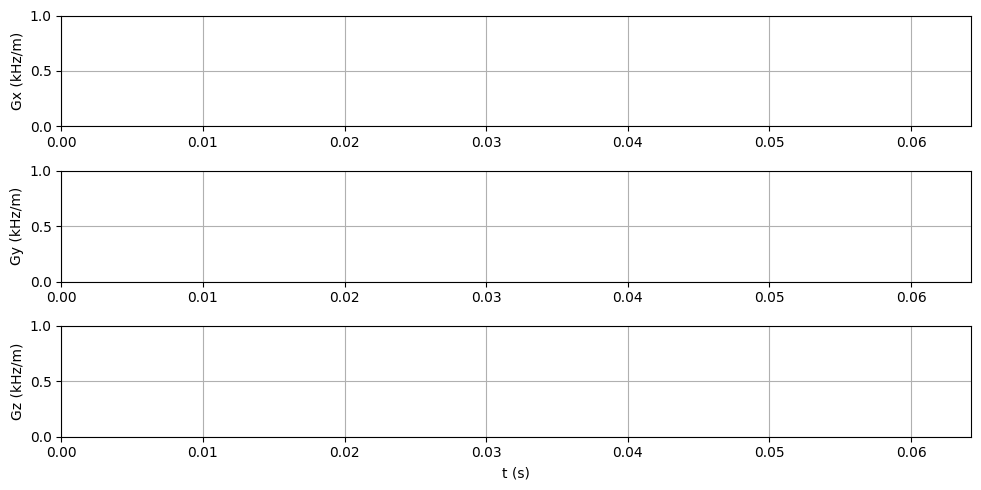

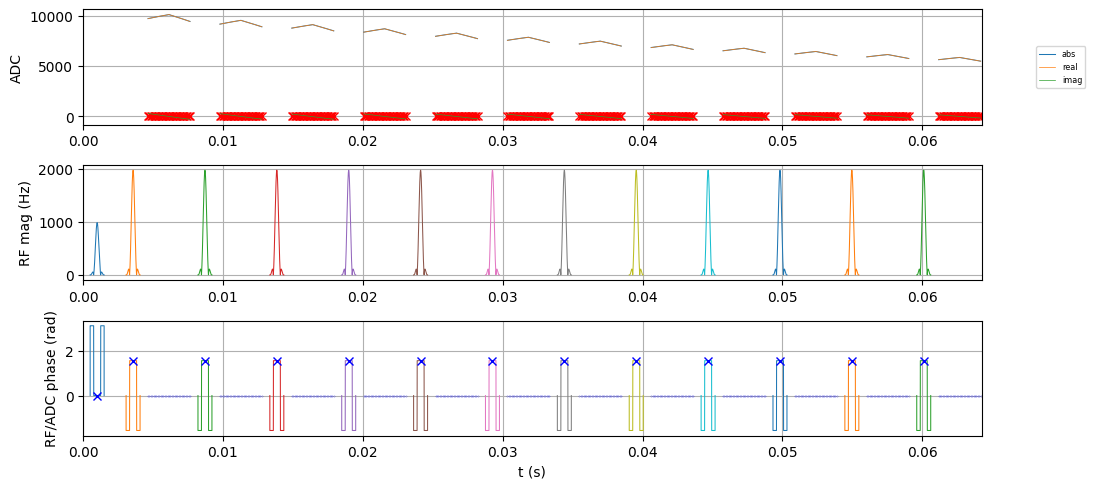

In [ ]:
#@title CMPG in a brain phantom - sequence
# %% DEFINE the sequence, FOV and resolution
fov = 200e-3
Nread = 31    #@param {type:"slider", min:0, max:512, step:1}
Nphase = 1
slice_thickness = 8e-3  # slice
refocusing_angle=180 #@param {type:"slider", min:0, max:360, step:1}
# Define rf events
ETL=12 #@param {type:"slider", min:1, max:32, step:1}
TE_ms=1 #@param {type:"slider", min:1, max:32, step:1}

seq = seq_cpmg(FAex=90, refocusing_angle=refocusing_angle, Nread=Nread, ETL=ETL, 
                TE_ms=TE_ms, fov=fov, slice_thickness=slice_thickness)

# %% SIMULATE  the CPMG.seq file and add acquired signal to ADC plot
#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


In [5]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

Timing check passed successfully
